# Fashion dataset

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import torch
import torch.nn as nn

# Definirea mediului pe care va rula codul de antrenare
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum
import warnings
warnings.filterwarnings('ignore')

Running code @ cuda


# 3.1 MLP pe atributele extrase în etapa 1

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

Epoch 1/25, Train Loss: 0.6290, Train Acc: 0.7751, Test Loss: 0.6222, Test Acc: 0.7649, Training Speed: 19519.66 samples/sec
Epoch 2/25, Train Loss: 0.4349, Train Acc: 0.8472, Test Loss: 0.6147, Test Acc: 0.7687, Training Speed: 24253.31 samples/sec
Epoch 3/25, Train Loss: 0.4047, Train Acc: 0.8574, Test Loss: 0.6259, Test Acc: 0.7686, Training Speed: 15331.33 samples/sec
Epoch 4/25, Train Loss: 0.3860, Train Acc: 0.8630, Test Loss: 0.6187, Test Acc: 0.7712, Training Speed: 24087.90 samples/sec
Epoch 5/25, Train Loss: 0.3750, Train Acc: 0.8667, Test Loss: 0.6330, Test Acc: 0.7665, Training Speed: 24586.33 samples/sec
Epoch 6/25, Train Loss: 0.3615, Train Acc: 0.8718, Test Loss: 0.6404, Test Acc: 0.7623, Training Speed: 24215.85 samples/sec
Epoch 7/25, Train Loss: 0.3493, Train Acc: 0.8743, Test Loss: 0.6315, Test Acc: 0.7714, Training Speed: 23852.58 samples/sec
Epoch 8/25, Train Loss: 0.3496, Train Acc: 0.8762, Test Loss: 0.6321, Test Acc: 0.7657, Training Speed: 20675.18 samples/sec


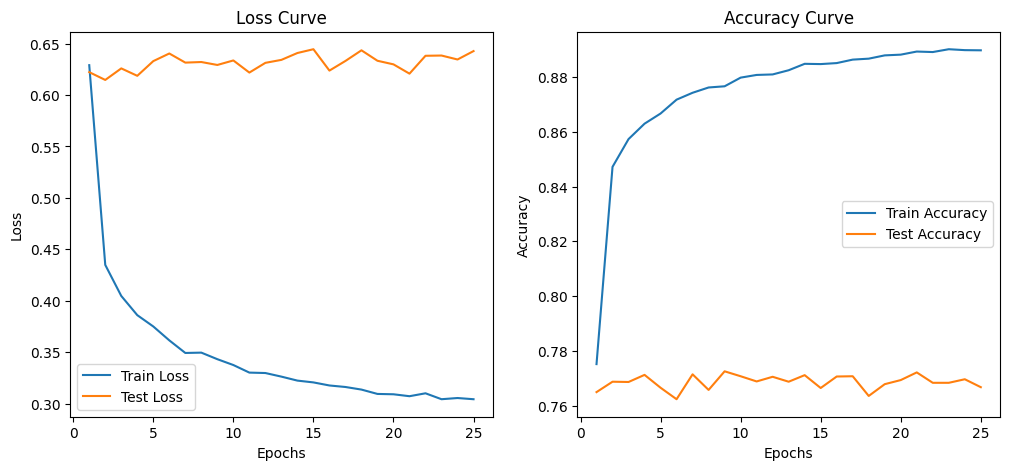

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load preprocessed data
data = np.load('/content/transformed_data_fashion.npz')
X_train, X_test = data['X_train_pca'], data['X_test_pca']
y_train, y_test = data['y_train'], data['y_test']

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model parameters
input_size = X_train.shape[1]
hidden_size = 256
num_classes = 10
learning_rate = 0.0005
num_epochs = 25
weight_decay = 1e-4
training_speeds = []
total_samples = 0
total_training_time = 0

model_1 = MLP(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    model_1.train()
    epoch_loss, correct, total = 0, 0, 0
    start_time = time.time()
    if torch.cuda.is_available():
          torch.cuda.synchronize()

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model_1(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    if torch.cuda.is_available():
            torch.cuda.synchronize()
    end_time = time.time()
    epoch_duration = end_time - start_time
    samples_per_second = total / epoch_duration
    training_speeds.append(samples_per_second)
    total_training_time += epoch_duration
    total_samples += total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Evaluation loop
    model_1.eval()
    test_loss, correct, total = 0, 0, 0

    # liste pentru a stoca predicțiile și etichetele reale
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model_1(X_batch)
            loss = criterion(outputs, y_batch)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

            # stocarea predicțiilor și a etichetelor reale
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}, "
          f"Training Speed: {samples_per_second:.2f} samples/sec")

# Calculate and display total training speed
total_training_speed = total_samples / total_training_time
print(f"Total Training Speed: {total_training_speed:.2f} samples/sec")
print(f"Total Training Time for Fashion-MNIST: {total_training_time:.2f} sec")

# Calcularea metricilor de performanță
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nMetrici de Performanță:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Adăugat: Apelarea funcției pentru metrici
accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()

# 3.2 Arhitectura de tip MLP direct peste imagini


Extragerea si pregatirea datelor

In [ ]:
import torchvision
import torchvision.transforms as transforms

# 1. Pregătirea datelor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = torchvision.datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, transform=transform, download=True)

# Check sizes of tensors
print(f'Size of training images {train_dataset.data.shape}')
print(f'Size of training labels {len(train_dataset.targets)}')
print(f'Size of test images {test_dataset.data.shape}')
print(f'Size of test labels {len(test_dataset.targets)}')

Size of training images torch.Size([60000, 28, 28])
Size of training labels 60000
Size of test images torch.Size([10000, 28, 28])
Size of test labels 10000


In [ ]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 64  #@param
BATCH_SIZE_TEST = 64  #@param
NO_WORKERS = 8  #@param
SHUFFLE_DATA = True

# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

Shape of training images: torch.Size([64, 784])
Shape of training labels: torch.Size([64])


In [ ]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TRAIN,
                                          shuffle=SHUFFLE_DATA,
                                          num_workers=NO_WORKERS)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')

Shape of test images: torch.Size([64, 784])
Shape of test labels: torch.Size([64])


# Clasa MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Antrenare

Epoch 1/25, Train Loss: 0.6386, Train Acc: 0.7647, Test Loss: 0.4631, Test Acc: 0.8318, Training Speed: 3394.09 samples/sec
Epoch 2/25, Train Loss: 0.4928, Train Acc: 0.8221, Test Loss: 0.4398, Test Acc: 0.8417, Training Speed: 3343.89 samples/sec
Epoch 3/25, Train Loss: 0.4595, Train Acc: 0.8347, Test Loss: 0.4107, Test Acc: 0.8464, Training Speed: 3312.92 samples/sec
Epoch 4/25, Train Loss: 0.4354, Train Acc: 0.8432, Test Loss: 0.4035, Test Acc: 0.8544, Training Speed: 3351.32 samples/sec
Epoch 5/25, Train Loss: 0.4242, Train Acc: 0.8469, Test Loss: 0.3964, Test Acc: 0.8613, Training Speed: 3447.24 samples/sec
Epoch 6/25, Train Loss: 0.4099, Train Acc: 0.8529, Test Loss: 0.3799, Test Acc: 0.8622, Training Speed: 3507.21 samples/sec
Epoch 7/25, Train Loss: 0.3987, Train Acc: 0.8555, Test Loss: 0.3774, Test Acc: 0.8641, Training Speed: 3702.34 samples/sec
Epoch 8/25, Train Loss: 0.3937, Train Acc: 0.8575, Test Loss: 0.3746, Test Acc: 0.8657, Training Speed: 3381.20 samples/sec
Epoch 9/

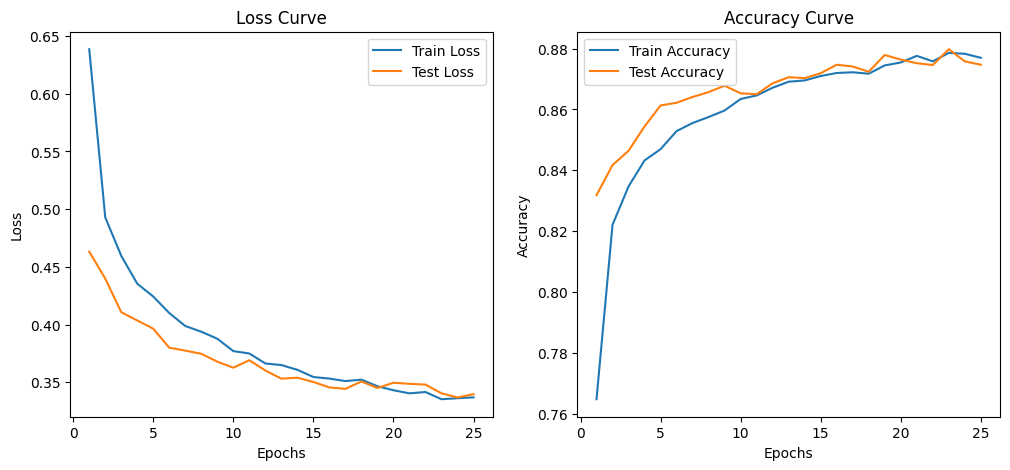

In [ ]:
# Initialize model, loss function, and optimizer
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

hidden_size = 256
input_size = 784  # 28x28 images
model_2 = MLP(input_size, hidden_size, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Training settings
num_epochs = 25
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
training_speeds = []
total_samples = 0
total_training_time = 0

# Training loop
for epoch in range(num_epochs):
    model_2.train()
    epoch_loss = 0
    correct, total = 0, 0
    start_time = time.time()
    if torch.cuda.is_available():
          torch.cuda.synchronize()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_2(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    if torch.cuda.is_available():
            torch.cuda.synchronize()
    end_time = time.time()
    epoch_duration = end_time - start_time
    samples_per_second = total / epoch_duration
    training_speeds.append(samples_per_second)
    total_training_time += epoch_duration
    total_samples += total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Evaluation loop
    model_2.eval()
    test_loss, correct, total = 0, 0, 0

    # liste pentru a stoca predicțiile și etichetele reale
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_2(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # stocarea predicțiilor și a etichetelor reale
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}, "
          f"Training Speed: {samples_per_second:.2f} samples/sec")

# Calculate and display total training speed
total_training_speed = total_samples / total_training_time
print(f"Total Training Speed: {total_training_speed:.2f} samples/sec")
print(f"Total Training Time for Fashion-MNIST: {total_training_time:.2f} sec")

# Calcularea metricilor de performanță
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nMetrici de Performanță:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

#  Apelarea funcției pentru metrici
accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)


# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


# 3.3 Arhitectura de tip convoluțional

In [ ]:
import torchvision
import torchvision.transforms as transforms

# 1. Pregătirea datelor
transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_no_aug = torchvision.datasets.FashionMNIST(root='data', train=True, transform=transform_no_aug, download=True)
train_dataset_aug = torchvision.datasets.FashionMNIST(root='data', train=True, transform=transform_aug, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, transform=transform_no_aug, download=True)

# Check sizes of tensors
print(f'Size of training images {train_dataset_no_aug.data.shape}')
print(f'Size of training labels {len(train_dataset_no_aug.targets)}')
print(f'Size of training images {train_dataset_aug.data.shape}')
print(f'Size of training labels {len(train_dataset_aug.targets)}')
print(f'Size of test images {test_dataset.data.shape}')
print(f'Size of test labels {len(test_dataset.targets)}')

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.66MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.5MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Size of training images torch.Size([60000, 28, 28])
Size of training labels 60000
Size of training images torch.Size([60000, 28, 28])
Size of training labels 60000
Size of test images torch.Size([10000, 28, 28])
Size of test labels 10000


In [ ]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 64  #@param
BATCH_SIZE_TEST = 64  #@param
NO_WORKERS = 8  #@param
SHUFFLE_DATA = True

train_loader_no_aug = torch.utils.data.DataLoader(train_dataset_no_aug, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)
train_loader_aug = torch.utils.data.DataLoader(train_dataset_aug, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TRAIN,
                                           shuffle=SHUFFLE_DATA,
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_no_aug_images, batch_train_labels) = next(iter(train_loader_no_aug))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_no_aug_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader_aug))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')

# get a training batch of images and labels
(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')



Shape of training images: torch.Size([64, 1, 28, 28])
Shape of training labels: torch.Size([64])
Shape of training images: torch.Size([64, 1, 28, 28])
Shape of training labels: torch.Size([64])
Shape of test images: torch.Size([64, 1, 28, 28])
Shape of test labels: torch.Size([64])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_pool(x)
        x = self.fc_layers(x)
        return x

Antrenare

Epoch [1/25]
No Augmentation: Train Loss: 0.9697, Train Acc: 0.7129, Test Loss: 0.7776, Test Acc: 0.7456, Train Speed: 3427.82 samples/sec
With Augmentation: Train Loss: 1.1712, Train Acc: 0.6233, Test Loss: 0.8829, Test Acc: 0.6887, Train Speed: 1743.27 samples/sec
Epoch [2/25]
No Augmentation: Train Loss: 0.6002, Train Acc: 0.8011, Test Loss: 0.5639, Test Acc: 0.8089, Train Speed: 3454.22 samples/sec
With Augmentation: Train Loss: 0.8314, Train Acc: 0.7217, Test Loss: 0.8335, Test Acc: 0.7046, Train Speed: 1737.32 samples/sec
Epoch [3/25]
No Augmentation: Train Loss: 0.5161, Train Acc: 0.8249, Test Loss: 0.5909, Test Acc: 0.7943, Train Speed: 3582.70 samples/sec
With Augmentation: Train Loss: 0.7379, Train Acc: 0.7442, Test Loss: 0.7250, Test Acc: 0.7497, Train Speed: 1780.78 samples/sec
Epoch [4/25]
No Augmentation: Train Loss: 0.4691, Train Acc: 0.8396, Test Loss: 0.5108, Test Acc: 0.8201, Train Speed: 3584.45 samples/sec
With Augmentation: Train Loss: 0.6930, Train Acc: 0.7578, Te

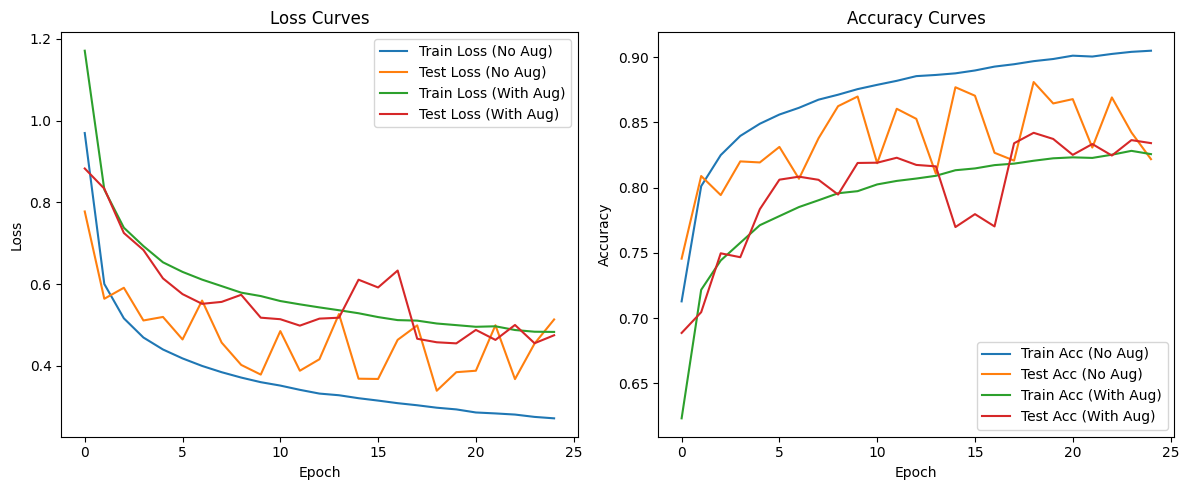

In [ ]:
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Initialize models, loss function, and optimizers for both cases
model_no_aug = CNN().to(device)
model_with_aug = CNN().to(device)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_no_aug = torch.optim.Adam(model_no_aug.parameters(), lr=learning_rate)
optimizer_with_aug = torch.optim.Adam(model_with_aug.parameters(), lr=learning_rate)
num_epochs = 25

# Training and evaluation loop with time and speed measurements
history = {'no_aug': {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'train_speed': []},
           'with_aug': {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'train_speed': []}}

total_training_time_no_aug, total_training_time_with_aug = 0, 0

def train_model(model, train_loader, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(train_loader), correct / len(train_loader.dataset)

def evaluate_model(model, test_loader):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(test_loader), correct / len(test_loader.dataset), all_labels, all_preds

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nMetrici de Performanță:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    #  model without augmentations
    model_no_aug.train()
    start_time = time.time()
    train_loss, train_acc = train_model(model_no_aug, train_loader_no_aug, optimizer_no_aug)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()
    epoch_duration = end_time - start_time
    train_speed = len(train_loader_no_aug.dataset) / epoch_duration
    total_training_time_no_aug += epoch_duration
    history['no_aug']['train_speed'].append(train_speed)

    test_loss, test_acc, y_true_no_aug, y_pred_no_aug = evaluate_model(model_no_aug, test_loader)

    history['no_aug']['train_loss'].append(train_loss)
    history['no_aug']['train_acc'].append(train_acc)
    history['no_aug']['test_loss'].append(test_loss)
    history['no_aug']['test_acc'].append(test_acc)

    print(f"No Augmentation: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Train Speed: {train_speed:.2f} samples/sec")

    #  model with augmentations
    model_with_aug.train()
    start_time = time.time()
    train_loss, train_acc = train_model(model_with_aug, train_loader_aug, optimizer_with_aug)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()
    epoch_duration = end_time - start_time
    train_speed = len(train_loader_aug.dataset) / epoch_duration
    total_training_time_with_aug += epoch_duration
    history['with_aug']['train_speed'].append(train_speed)

    test_loss, test_acc, y_true_with_aug, y_pred_with_aug = evaluate_model(model_with_aug, test_loader)

    history['with_aug']['train_loss'].append(train_loss)
    history['with_aug']['train_acc'].append(train_acc)
    history['with_aug']['test_loss'].append(test_loss)
    history['with_aug']['test_acc'].append(test_acc)

    print(f"With Augmentation: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
          f"Train Speed: {train_speed:.2f} samples/sec")

# Calculate and display total training speed and time
total_samples_no_aug = len(train_loader_no_aug.dataset) * num_epochs
total_samples_with_aug = len(train_loader_aug.dataset) * num_epochs

overall_speed_no_aug = total_samples_no_aug / total_training_time_no_aug
overall_speed_with_aug = total_samples_with_aug / total_training_time_with_aug

print(f"Total Training Speed (No Augmentation): {overall_speed_no_aug:.2f} samples/sec")
print(f"Total Training Time (No Augmentation): {total_training_time_no_aug:.2f} sec")

print(f"Total Training Speed (With Augmentation): {overall_speed_with_aug:.2f} samples/sec")
print(f"Total Training Time (With Augmentation): {total_training_time_with_aug:.2f} sec")

# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(history['no_aug']['train_loss'], label='Train Loss (No Aug)')
plt.plot(history['no_aug']['test_loss'], label='Test Loss (No Aug)')
plt.plot(history['with_aug']['train_loss'], label='Train Loss (With Aug)')
plt.plot(history['with_aug']['test_loss'], label='Test Loss (With Aug)')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['no_aug']['train_acc'], label='Train Acc (No Aug)')
plt.plot(history['no_aug']['test_acc'], label='Test Acc (No Aug)')
plt.plot(history['with_aug']['train_acc'], label='Train Acc (With Aug)')
plt.plot(history['with_aug']['test_acc'], label='Test Acc (With Aug)')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nMetrici de Performanță:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Calcularea metricilor pentru modelul fără augmentări
print("\nMetrici pentru modelul fără augmentări:")
accuracy_no_aug, precision_no_aug, recall_no_aug, f1_no_aug = calculate_metrics(y_true_no_aug, y_pred_no_aug)

# Calcularea metricilor pentru modelul cu augmentări
print("\nMetrici pentru modelul cu augmentări:")
accuracy_with_aug, precision_with_aug, recall_with_aug, f1_with_aug = calculate_metrics(y_true_with_aug, y_pred_with_aug)

# Afișarea metricilor într-un tabel simplu
import pandas as pd

metrics_df = pd.DataFrame({
    "Model": ["No Augmentation", "With Augmentation"],
    "Accuracy": [accuracy_no_aug, accuracy_with_aug],
    "Precision": [precision_no_aug, precision_with_aug],
    "Recall": [recall_no_aug, recall_with_aug],
    "F1 Score": [f1_no_aug, f1_with_aug]
})

print("\nTabel comparativ al metricilor de performanță:")
print(metrics_df)

# Salvarea tabelului într-un fișier CSV (opțional)
metrics_df.to_csv("comparison_metrics.csv", index=False)



Metrici pentru modelul fără augmentări:

Metrici de Performanță:
Accuracy: 0.8218
Precision: 0.8661
Recall: 0.8218
F1 Score: 0.8180

Metrici pentru modelul cu augmentări:

Metrici de Performanță:
Accuracy: 0.8341
Precision: 0.8382
Recall: 0.8341
F1 Score: 0.8284

Tabel comparativ al metricilor de performanță:
               Model  Accuracy  Precision  Recall  F1 Score
0    No Augmentation    0.8218   0.866084  0.8218  0.818050
1  With Augmentation    0.8341   0.838244  0.8341  0.828388


# 3.4. Utilizarea unei proceduri de finetuning peste arhitectura ResNet-18

In [ ]:
import time
# Training and evaluation loop
def train_model(model, train_loader, test_loader, num_epochs):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    training_speeds = []
    total_samples = 0
    total_training_time = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct, total = 0, 0
        start_time = time.time()
        if torch.cuda.is_available():
          torch.cuda.synchronize()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.time()
        epoch_duration = end_time - start_time
        samples_per_second = total / epoch_duration
        training_speeds.append(samples_per_second)
        total_training_time += epoch_duration
        total_samples += total

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Evaluation loop
        model.eval()
        test_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}, "
              f"Training Speed: {samples_per_second:.2f} samples/sec")

        scheduler.step()

    return train_losses, test_losses, train_accuracies, test_accuracies, total_training_time, total_samples

Epoch 1/25, Train Loss: 0.4182, Train Acc: 0.8516, Test Loss: 0.2922, Test Acc: 0.8969, Training Speed: 1613.75 samples/sec
Epoch 2/25, Train Loss: 0.2532, Train Acc: 0.9080, Test Loss: 0.2597, Test Acc: 0.9060, Training Speed: 1568.34 samples/sec
Epoch 3/25, Train Loss: 0.2089, Train Acc: 0.9228, Test Loss: 0.2358, Test Acc: 0.9190, Training Speed: 1609.27 samples/sec
Epoch 4/25, Train Loss: 0.1785, Train Acc: 0.9347, Test Loss: 0.2334, Test Acc: 0.9181, Training Speed: 1591.32 samples/sec
Epoch 5/25, Train Loss: 0.1559, Train Acc: 0.9420, Test Loss: 0.2302, Test Acc: 0.9208, Training Speed: 1602.84 samples/sec
Epoch 6/25, Train Loss: 0.1115, Train Acc: 0.9588, Test Loss: 0.2241, Test Acc: 0.9263, Training Speed: 1310.98 samples/sec
Epoch 7/25, Train Loss: 0.0998, Train Acc: 0.9633, Test Loss: 0.2240, Test Acc: 0.9243, Training Speed: 1451.20 samples/sec
Epoch 8/25, Train Loss: 0.0950, Train Acc: 0.9652, Test Loss: 0.2284, Test Acc: 0.9255, Training Speed: 1532.55 samples/sec
Epoch 9/

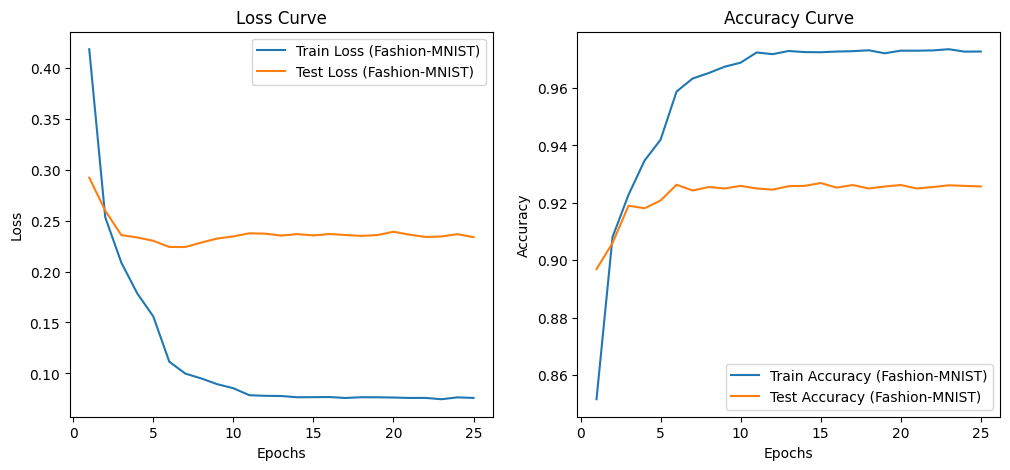

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

# Hyperparameters
num_epochs = 25
batch_size = 64
learning_rate = 0.001
NO_WORKERS = 8

transform_fashion_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset_fashion = FashionMNIST(root='./data', train=True, download=True, transform=transform_fashion_mnist)
test_dataset_fashion = FashionMNIST(root='./data', train=False, download=True, transform=transform_fashion_mnist)

train_loader_fashion = DataLoader(train_dataset_fashion, batch_size=batch_size, shuffle=True, num_workers=NO_WORKERS)
test_loader_fashion = DataLoader(test_dataset_fashion, batch_size=batch_size, shuffle=False, num_workers=NO_WORKERS)

# Load pre-trained ResNet-18 model
model_4 = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_fashion_classes = 10
num_features = model_4.fc.in_features
model_4.fc = nn.Linear(num_features, num_fashion_classes)

model_4 = model_4.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=learning_rate, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training for Fashion-MNIST
train_losses_fashion, test_losses_fashion, train_accuracies_fashion, test_accuracies_fashion, total_time_fashion, total_samples_fashion = train_model(model_4, train_loader_fashion, test_loader_fashion, num_epochs)

# Calculate and display total training speed
training_speed_fashion = total_samples_fashion / total_time_fashion
print(f"Total Training Speed for Fashion-MNIST: {training_speed_fashion:.2f} samples/sec")
print(f"Total Training Time for Fashion-MNIST: {total_time_fashion:.2f} sec")

# Calcularea metricilor de performanță
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nMetrici de Performanță:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

# Extracția predicțiilor și a etichetelor reale
def extract_predictions(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Calcularea și afișarea metricilor
y_true, y_pred = extract_predictions(model_4, test_loader_fashion)
calculate_metrics(y_true, y_pred)


# Plotting the results
plt.figure(figsize=(12, 5))

# Loss Curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses_fashion, label='Train Loss (Fashion-MNIST)')
plt.plot(range(1, num_epochs+1), test_losses_fashion, label='Test Loss (Fashion-MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies_fashion, label='Train Accuracy (Fashion-MNIST)')
plt.plot(range(1, num_epochs+1), test_accuracies_fashion, label='Test Accuracy (Fashion-MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


